In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cvcclinicdb/class_dict.csv
/kaggle/input/cvcclinicdb/metadata.csv
/kaggle/input/cvcclinicdb/TIF/Ground Truth/274.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/315.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/123.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/130.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/508.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/170.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/371.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/597.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/590.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/66.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/612.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/459.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/296.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/523.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/495.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/411.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/576.tif
/kaggle/input/cvcclinicdb/TIF/Ground Truth/473.tif
/ka

In [53]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D , Activation , BatchNormalization
from tensorflow.keras.layers import UpSampling2D , Input , Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.metrics import Recall , Precision
from tensorflow.keras import backend as K

In [54]:
print("Tensorflow Version : " , tf.__version__)

Tensorflow Version :  2.13.0


In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
IMAGE_SIZE = 256
EPOCHS = 8
LR = 1e-4
BATCH = 8

MASK_DIR = '/kaggle/input/polypseg/CVC-ColonDB/CVC-ColonDB/masks'
IMAGE_DIR = '/kaggle/input/polypseg/CVC-ColonDB/CVC-ColonDB/images'

PATH_PNG = '/kaggle/input/cvcclinicdb/PNG/'
PATH_TIF = '/kaggle/input/cvcclinicdb/TIF/'

In [57]:
def load_data(path , split = 0.1):
    images = sorted(glob(os.path.join(path ,"Original/*")))
    masks = sorted(glob(os.path.join(path , "Ground Truth/*")))
    
    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    
#     train_x , valid_x = train_test_split(images , test_size = valid_size , random_state = 42)
#     train_y , valid_y = train_test_split(masks , test_size = valid_size , random_state = 42)
    
#     train_x , test_x = train_test_split(images , test_size = test_size , random_state = 42)
#     train_y , test_y = train_test_split(masks , test_size = test_size , random_state = 42)

    train_x, temp_x, train_y, temp_y = train_test_split(images, masks, test_size=valid_size, random_state=42)
    valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)
    
    
    return (train_x , train_y) , (valid_x , valid_y) , (test_x , test_y)

In [58]:
# def read_image(path):
#     path = path.decode()
#     x = cv2.imread(path , cv2.IMREAD_COLOR)
#     x = cv2.resize(x , (IMAGE_SIZE , IMAGE_SIZE))
#     x = x / 255.0

# def read_mask(path):
#     x = path.decode()
#     x = cv2.imread(path , cv2.IMREAD_COLOR)
#     x = cv2.resize(x , (IMAGE_SIZE , IMAGE_SIZE))
#     x = x / 255.0
#     x = np.expand_dims(x , axis = -1)
#     return x

In [59]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path , cv2.IMREAD_COLOR)
    x = cv2.resize(x , (IMAGE_SIZE , IMAGE_SIZE))
    x = x / 255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path , cv2.IMREAD_COLOR)
    x = cv2.resize(x , (IMAGE_SIZE , IMAGE_SIZE))
    x = x / 255.0
#     x = np.expand_dims(x , axis = -1)
#     print("Shape after resize and normalization:", x.shape)
    x = x[:, :, 0]  # Keep only the first channel (assuming it's a grayscale mask)
    x = np.expand_dims(x, axis=-1)  # Ensure single channel
#     print("Shape after expand_dims:", x.shape)
    return x

In [60]:
def tf_parse(sx , sy):
    def _parse(sx , sy):
        sx = read_image(sx)
        sy = read_mask(sy)
        return sx , sy
    
    sx , sy = tf.numpy_function(_parse , [sx , sy] , [tf.float64 , tf.float64])
    sx.set_shape([256 , 256 , 3])
    sy.set_shape([256 , 256 , 1])
    return sx , sy

def tf_dataset(x , y , batch):
    dataset = tf.data.Dataset.from_tensor_slices((x , y))
    dataset = dataset.shuffle(buffer_size=len(x))  # Shuffle the dataset
    dataset = dataset.map(tf_parse , num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch , drop_remainder = True)
    dataset = dataset.repeat()
    
    return dataset

In [61]:
(train_x , train_y) , (valid_x , valid_y) , (test_x , test_y) = load_data(PATH_TIF)

In [62]:
print("Training Data : " , len(train_x))
print("Test Data : " , len(test_x))
print("Validation Data : " , len(valid_x))

Training Data :  551
Test Data :  31
Validation Data :  30


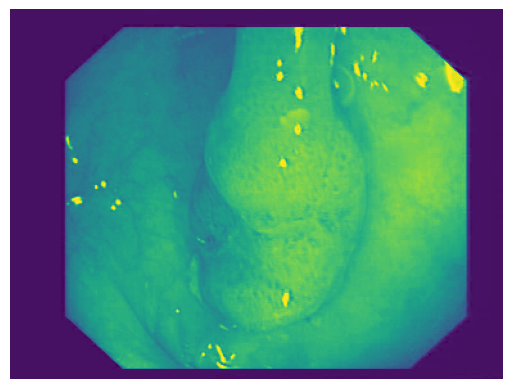

In [63]:
images1 = sorted(glob(os.path.join(PATH_TIF ,"Original//*")))
image_bgr = cv2.imread(images1[13] , cv2.IMREAD_UNCHANGED)
# print(image_bgr)
# print(image_bgr.shape)

# Convert BGR to RGB
# image_rgb = cv2.cvtColor(image_bgr , cv2.COLOR_BGR2YCrCb)


# print(image_rgb)
# print(image_rgb.shape)

# Display the image using matplotlib
plt.imshow(image_bgr)
plt.axis('off')  # Turn off axis labels
plt.show()

In [64]:
def read_and_rgb(x):
    x = cv2.imread(x , cv2.IMREAD_UNCHANGED)
#     print(x.shape)  # Print the shape of the array
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

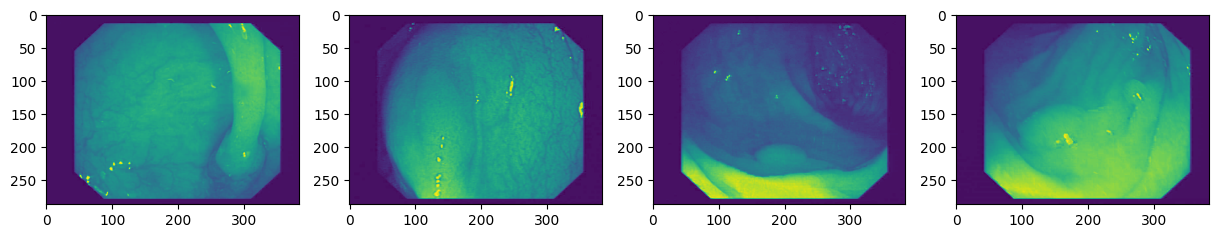

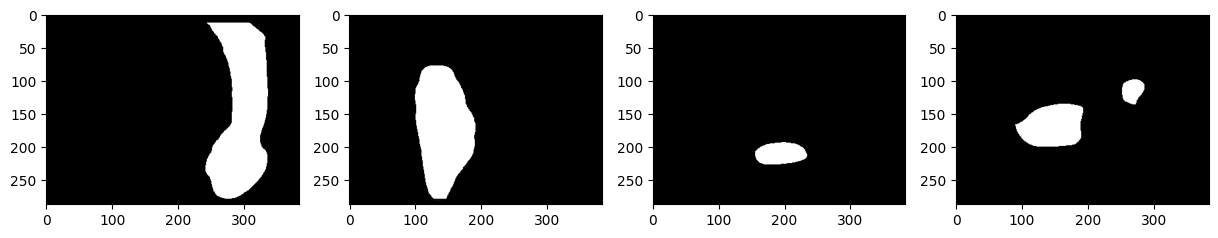

In [65]:
fig = plt.figure(figsize = (15 , 15))

a = fig.add_subplot(1 , 4 , 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

b = fig.add_subplot(1 , 4 , 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
# imgplot.set_clim(0.0 , 0.7)

c = fig.add_subplot(1 , 4 , 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
# imgplot.set_clim(0.0 , 1.4)

c = fig.add_subplot(1 , 4 , 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
# imgplot.set_clim(0.0 , 2.1)

fig = plt.figure(figsize = (15 , 15))

a = fig.add_subplot(1 , 4 , 1)
imgplot = plt.imshow(cv2.cvtColor(read_and_rgb(train_y[0]) , cv2.COLOR_BGR2RGB))

b = fig.add_subplot(1 , 4 , 2)
imgplot = plt.imshow(cv2.cvtColor(read_and_rgb(train_y[1]) , cv2.COLOR_BGR2RGB))
# imgplot.set_clim(0.0 , 0.7)

c = fig.add_subplot(1 , 4 , 3)
imgplot = plt.imshow(cv2.cvtColor(read_and_rgb(train_y[2]) , cv2.COLOR_BGR2RGB))
# imgplot.set_clim(0.0 , 1.4)

c = fig.add_subplot(1 , 4 , 4)
imgplot = plt.imshow(cv2.cvtColor(read_and_rgb(train_y[3]) , cv2.COLOR_BGR2RGB))
# imgplot.set_clim(0.0 , 2.1)

In [66]:
def build_model():
    inputs = Input(shape = (IMAGE_SIZE , IMAGE_SIZE , 3) , name = "input_image")
    
    #Pre-trained Encoder
    encoder = MobileNetV2(input_tensor = inputs , weights = "imagenet" , include_top = False , alpha = 0.35)
    skip_connection_names = ["input_image" , "block_1_expand_relu" , "block_3_expand_relu" , "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output   #(16 x 16)  ---> BottleNeck Layer
    
    f = [16 , 32 , 48 ,64]   #no.of filters
    x = encoder_output
    
    for i in range(1 , len(f)+1 , 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2 , 2))(x)
        x = Concatenate()([x , x_skip])
        
        x = Conv2D(f[-i] , (3,3) , padding = "same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i] , (3,3) , padding = "same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    
    x = Conv2D(1 , (1,1) , padding = "same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs , x)
    return model

In [67]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 16)         432       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 16)         0         ['bn_Conv1[0][0]']      

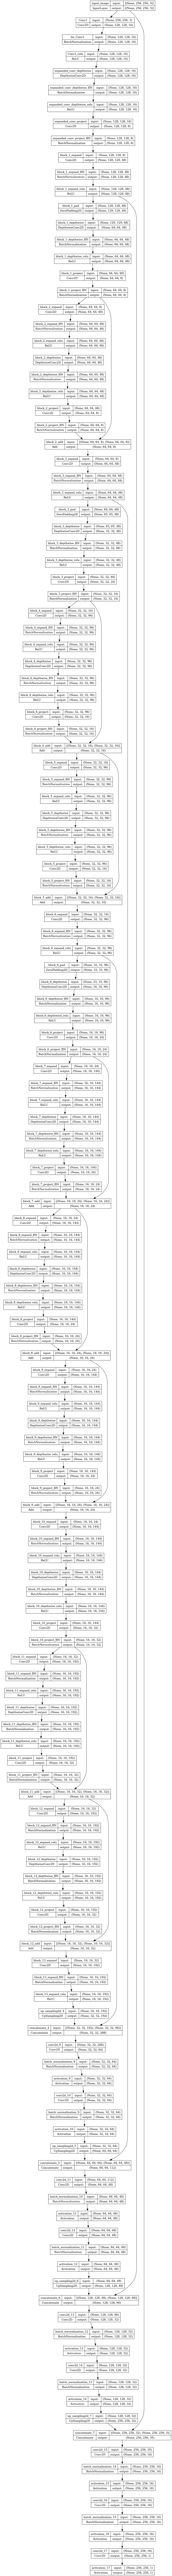

In [68]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [69]:
smooth = 1e-15
def dice_coeff(y_true , y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true , y_pred):
    return 1.0 - dice_coeff(y_true , y_pred)

In [70]:
train_dataset = tf_dataset(train_x , train_y , batch = BATCH)
valid_dataset = tf_dataset(valid_x , valid_y , batch = BATCH)

In [71]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coeff , Recall() , Precision()]
model.compile(loss = dice_loss , optimizer = opt , metrics = metrics)

In [72]:
callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.1 , patience = 4),
    EarlyStopping(monitor = 'val_loss' , patience = 10 , restore_best_weights = False)
]

In [78]:
train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 100,
    steps_per_epoch = train_steps,
    validation_steps = valid_steps,
    callbacks = callbacks
)

Epoch 1/100
69/69 [==============================] - 3s 48ms/step - loss: 0.1694 - dice_coeff: 0.8306 - recall_2: 0.9512 - precision_2: 0.9669 - val_loss: 0.3117 - val_dice_coeff: 0.6883 - val_recall_2: 0.7482 - val_precision_2: 0.8263 - lr: 1.0000e-04
Epoch 2/100
69/69 [==============================] - 3s 48ms/step - loss: 0.1618 - dice_coeff: 0.8382 - recall_2: 0.9494 - precision_2: 0.9693 - val_loss: 0.3311 - val_dice_coeff: 0.6689 - val_recall_2: 0.6247 - val_precision_2: 0.8880 - lr: 1.0000e-04
Epoch 3/100
69/69 [==============================] - 3s 47ms/step - loss: 0.1504 - dice_coeff: 0.8496 - recall_2: 0.9515 - precision_2: 0.9714 - val_loss: 0.3112 - val_dice_coeff: 0.6888 - val_recall_2: 0.7841 - val_precision_2: 0.7772 - lr: 1.0000e-04
Epoch 4/100
69/69 [==============================] - 3s 48ms/step - loss: 0.1502 - dice_coeff: 0.8498 - recall_2: 0.9490 - precision_2: 0.9696 - val_loss: 0.2818 - val_dice_coeff: 0.7182 - val_recall_2: 0.8028 - val_precision_2: 0.8160 - lr:

In [79]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

4/4 [==============================] - 0s 28ms/step - loss: 0.1485 - dice_coeff: 0.8515 - recall_2: 0.8528 - precision_2: 0.9441


[0.14849305152893066,
 0.8515069484710693,
 0.8528223037719727,
 0.9441453218460083]

In [80]:
def read_image1(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask1(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [81]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 22ms/step


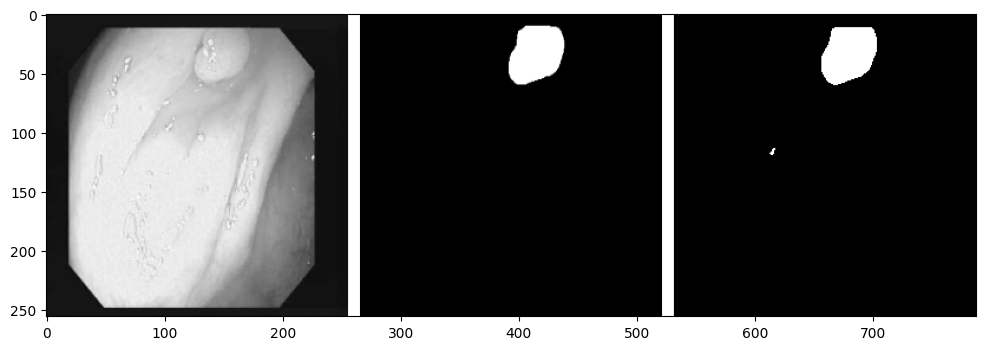

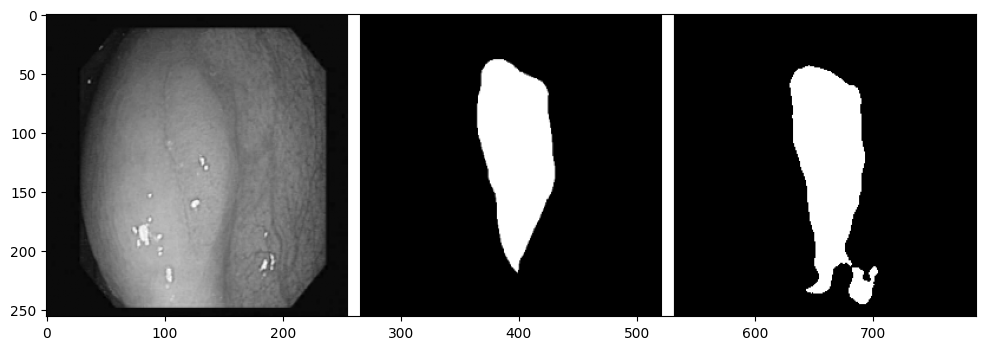

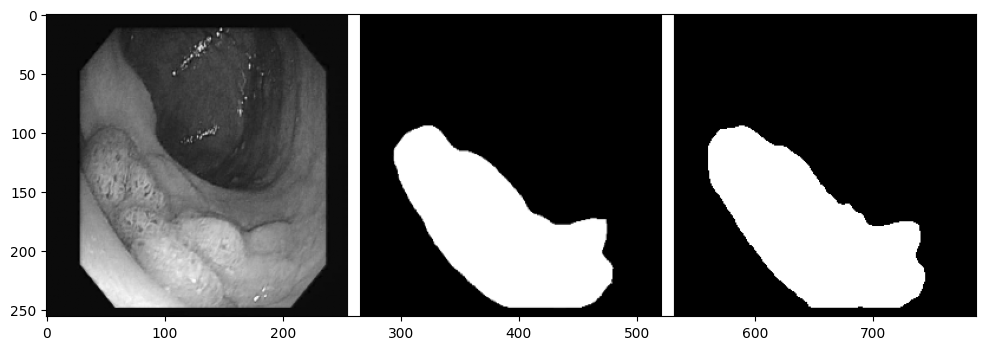

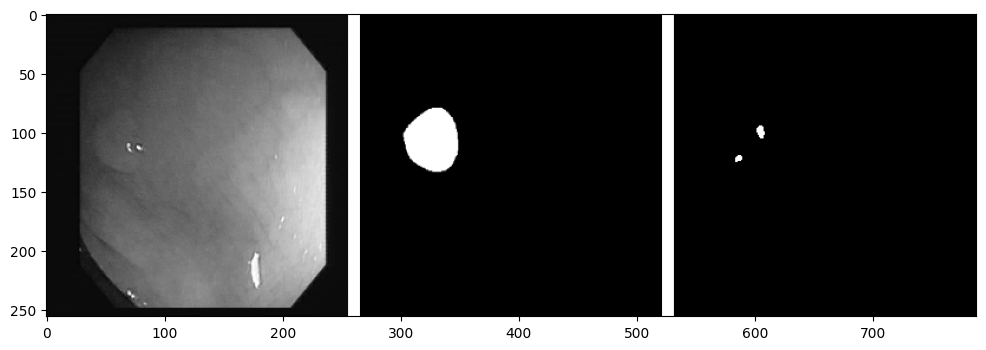

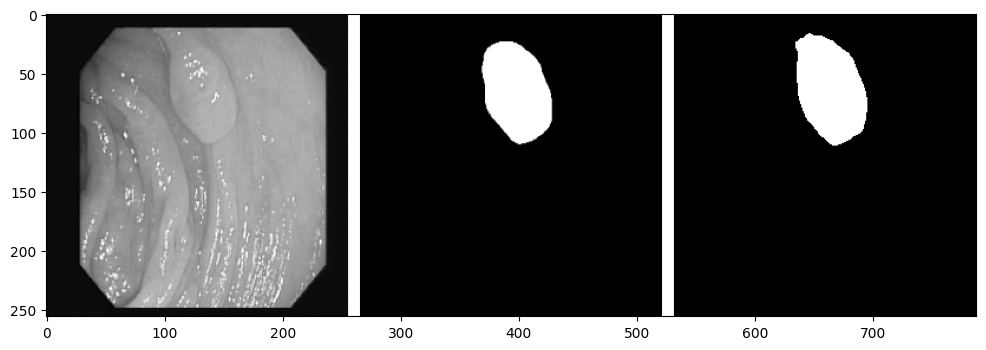

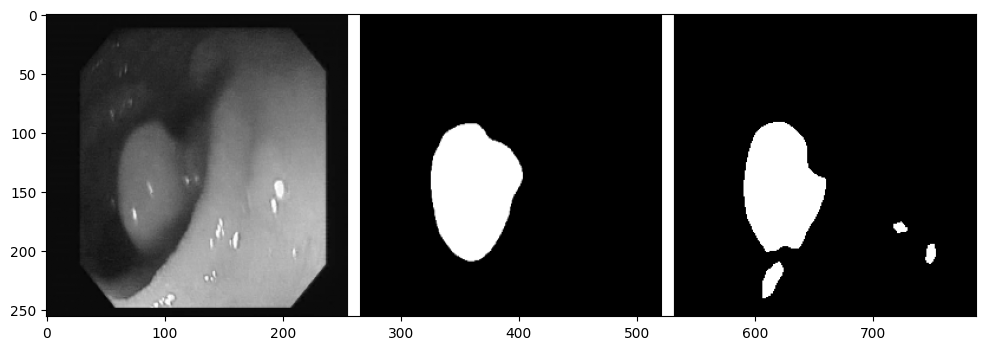

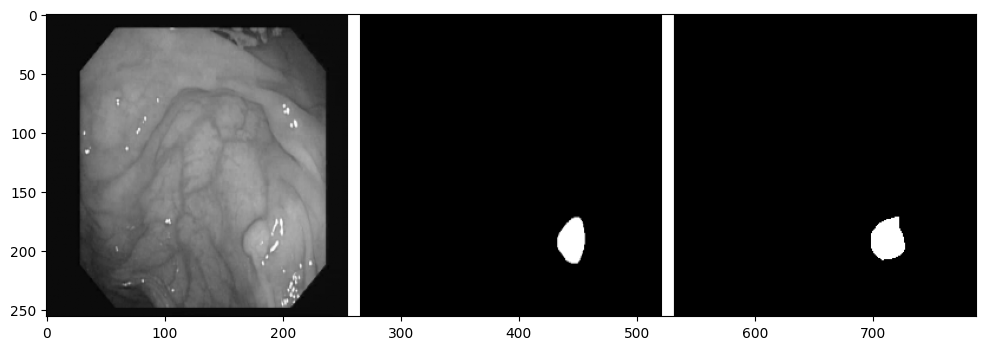

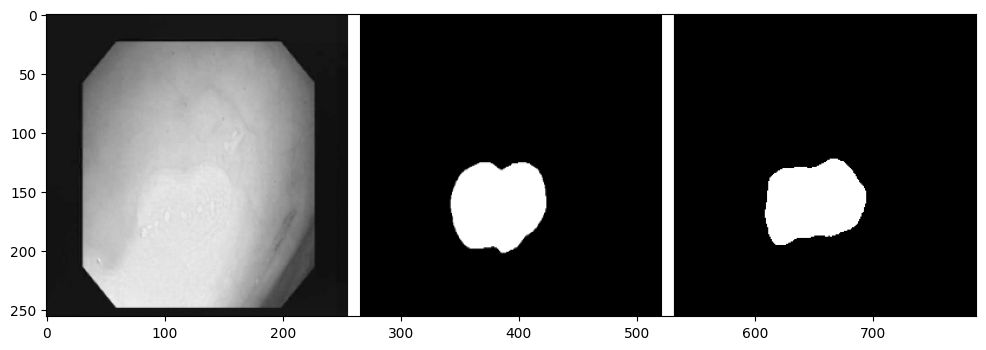

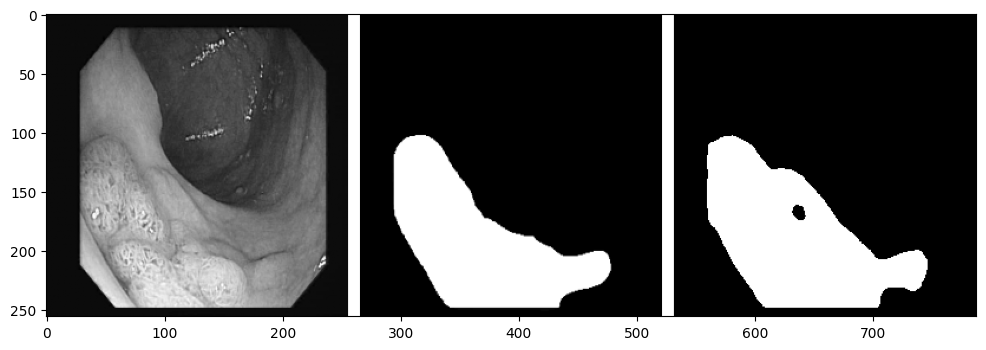

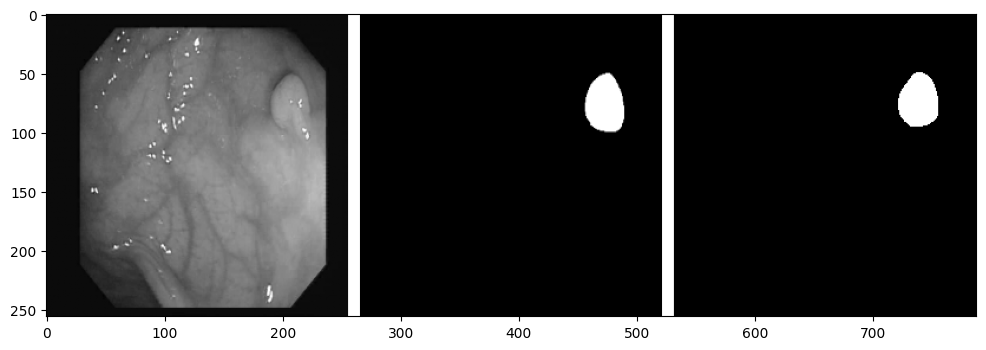

In [82]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image1(x)
    y = read_mask1(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)